In [8]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

In [9]:
def merge_csv_files(directory_path):
    file_list = os.listdir(directory_path)

    combined_df = pd.DataFrame()

    for file_name in file_list:
        file_path = os.path.join(directory_path, file_name)
        if os.path.isfile(file_path) and file_name.endswith(".csv"):
            df = pd.read_csv(file_path)
            combined_df = pd.concat([combined_df, df], ignore_index=True)

    return combined_df


directory_path = "/Users/sergi/PycharmProjects/PythonEnv/Методы визуализации данных/lab1/Исходные данные"

result_df = merge_csv_files(directory_path)
result_df = result_df.drop_duplicates()
result_df.shape


(23625, 58)

In [10]:
result_df.head()

,mark,model,pokolenie,car_type,год выпуска,Цена,Пробег,Цвет,"Выбросы CO2, г/км",Высота,...,Тип передней подвески,Тип привода,Топливо,Число клапанов на цилиндр,Ширина,Ширина задней колеи,Ширина передней колеи,Экологический класс,Оценка безопасности,Название рейтинга
0,Mercedes-Benz,G-Класс AMG,II (W463) 2018 – н.в.,Внедорожник 5 дв.,2020.0,20 000 000 ₽,8000.0,белый,304.0,1984.0,...,"независимая, пружинная",полный,АИ-98,4.0,1984.0,1654.0,1654.0,Euro 6,NaN,NaN
1,Mercedes-Benz,G-Класс AMG,II (W463) 2018 – н.в.,Внедорожник 5 дв.,2019.0,15 499 999 ₽,35000.0,чёрный,304.0,1984.0,...,"независимая, пружинная",полный,АИ-98,4.0,1984.0,1654.0,1654.0,Euro 6,NaN,NaN
2,Mercedes-Benz,G-Класс AMG,II (W463) 2018 – н.в.,Внедорожник 5 дв.,2020.0,19300000₽,0.0,Чёрный,304.0,1984.0,...,"независимая, пружинная",полный,АИ-98,4.0,1984.0,1654.0,1654.0,Euro 6,NaN,NaN
3,Mercedes-Benz,G-Класс AMG,II (W463) 2018 – н.в.,Внедорожник 5 дв.,2020.0,28300000₽,0.0,Чёрный,304.0,1984.0,...,"независимая, пружинная",полный,АИ-98,4.0,1984.0,1654.0,1654.0,Euro 6,NaN,NaN
4,Mercedes-Benz,G-Класс AMG,II (W463) 2018 – н.в.,Внедорожник 5 дв.,2019.0,18 350 000 ₽,14200.0,белый,304.0,1984.0,...,"независимая, пружинная",полный,АИ-98,4.0,1984.0,1654.0,1654.0,Euro 6,NaN,NaN


In [11]:
result_df.dtypes

mark                                             object
model                                            object
pokolenie                                        object
car_type                                         object
год выпуска                                     float64
Цена                                             object
Пробег                                          float64
Цвет                                             object
Выбросы CO2, г/км                               float64
Высота                                          float64
Диаметр цилиндра и ход поршня, мм                object
Длина                                           float64
Задние тормоза                                   object
Класс автомобиля                                 object
Клиренс                                          object
Количество дверей                               float64
Количество мест                                  object
Количество передач                              

In [12]:
pd.to_numeric(result_df['Клиренс'], errors="coerce")

0          NaN
1          NaN
2          NaN
3          NaN
4          NaN
         ...  
80900    180.0
80901    180.0
80958    195.0
80990    195.0
81046    215.0
Name: Клиренс, Length: 23625, dtype: float64

In [13]:
def split_columns_by_type(df) -> list:
    num_cols = [col for col in df.columns if df[col].dtype != object]
    cat_cols = [col for col in df.columns if df[col].dtype == object]

    return [num_cols, cat_cols]


def preprocess_data(df: pd.DataFrame):
    # Преобразуем поле цены в числовой формат
    df = df.copy()
    df['Цена'] = df['Цена'].str.replace('\xa0', '').str.replace('₽', '').astype(float)

    # Применяем eval с обработкой ошибок
    def safe_eval(value):
        try:
            return eval(value)
        except (SyntaxError, TypeError, NameError):
            return pd.NaT
    
    # Преобразуем оценку в относительну величину 4 / 5 = 0.8, 4 / 4 = 1 и тд
    not_na = ~df["Оценка безопасности"].isna()
    df[not_na]["Оценка безопасности"] = df[not_na]["Оценка безопасности"].apply(safe_eval)

    # Преобразуем мощность в число
    df['Мощность'] = df['Мощность'].replace('[^\d]', '', regex=True).astype(float).isna()

    # Преобразование количество мест в число
    # '5', '5, 7' - может быть несколько значений, поэтому необходимо будет explode таблицы => размерность может увеличиться
    df['Количество мест'] = df['Количество мест'].str.split(', ')
    df = df.explode(column='Количество мест')
    df['Количество мест'] = pd.to_numeric(df['Количество мест'], errors='coerce')


    df['Клиренс'] = pd.to_numeric(df['Клиренс'], errors="coerce")

    df['Максимальная мощность, л.с./кВт при об/мин'] = [float(str(i).split('/')[0].strip())
                                                        if str(i).split('/')[0].strip() != 'nan'
                                                        else 0
                                                        for i in df['Максимальная мощность, л.с./кВт при об/мин']]

    df['Максимальный крутящий момент, Н*м при об/мин'] = [float(i.split(' ')[0])
                                                            if str(i).split('/')[0].strip() != 'nan'
                                                            else 0
                                                            for i in df['Максимальный крутящий момент, Н*м при об/мин']]


    df['Объем'] = [float(i.split(' ')[0])
                        if str(i).split('/')[0].strip() != 'nan'
                        else 0
                        for i in df['Объем']]

    df['Объем багажника max'] = [float(str(i).split('/')[0])
                                    if str(i).split('/')[0] not in ['nan', '-'] 
                                    else 0
                                    for i in df['Объем багажника мин/макс, л']]

    df['Объем багажника min'] = [float(str(i).split('/')[1])
                                    if len(str(i).split('/')) != 1
                                    else 0
                                    for i in df['Объем багажника мин/макс, л']]

    df['Расход'] = [float(str(i).split(' ')[0])
                        if len(str(i).split(' ')) != 1
                        else 0
                        for i in df['Расход']]

    df['Расход л город'] = [float(str(i).split('/')[0])
                                if len(str(i).split('/')) != 1
                                else 0
                                for i in df['Расход топлива, л город/трасса/смешанный']]

    df['Расход л трасса'] = [float(str(i).split('/')[1])
                                if len(str(i).split('/')) != 1
                                else 0
                                for i in df['Расход топлива, л город/трасса/смешанный']]

    df['Расход л среднее'] = [float(str(i).split('/')[2])
                                if len(str(i).split('/')) != 1
                                else 0
                                for i in df['Расход топлива, л город/трасса/смешанный']]

    df.drop(['Расход топлива, л город/трасса/смешанный'], axis = 1, inplace = True)
    df.drop(['Объем багажника мин/макс, л'], axis = 1, inplace = True)
    df.drop(['Разгон'], axis = 1, inplace = True)
    df.drop(['Мощность'], axis = 1, inplace = True)
    df.drop(['Коробка передач'], axis = 1, inplace = True)

    df.drop_duplicates()

    numbers_cols, categorical_cols = split_columns_by_type(df)

    #    Замена пропущенных числовых значений на медиану
    df[numbers_cols] = df[numbers_cols].fillna(df[numbers_cols].median())
    #    Замена пропущенных категориальных значений на моду
    df[categorical_cols] = df[categorical_cols].fillna(df[categorical_cols].mode().iloc[0])
    
    return df

In [14]:
df = preprocess_data(result_df)

In [15]:
df.isna().sum().sum()

0

1.	Постройте распределение цен автомобилей и если наблюдается сильный скос, то прологарифмируйте цены.

In [16]:
def price_distribution():
    # Визуализируем распределение цен
    plt.figure(figsize=(10, 6))
    plt.hist(df['Цена'], bins=20, edgecolor='black')
    plt.title('Distribution of Prices')
    plt.xlabel('Price')
    plt.ylabel('Frequency')
    plt.show()

    # Проверяем наличие сильного скоса
    skewness = df['Цена'].skew()
    print(f"Скос: {skewness}")

    # Если есть сильный скос, логарифмируем цены
    if abs(skewness) > 1:
        log_price = np.log1p(df['Цена'])

        # Визуализируем распределение логарифмированных цен
        plt.figure(figsize=(10, 6))
        plt.hist(log_price, bins=20, edgecolor='black')
        plt.title('Distribution of Log-transformed Prices')
        plt.xlabel('Log-transformed Price')
        plt.ylabel('Frequency')
        plt.show()

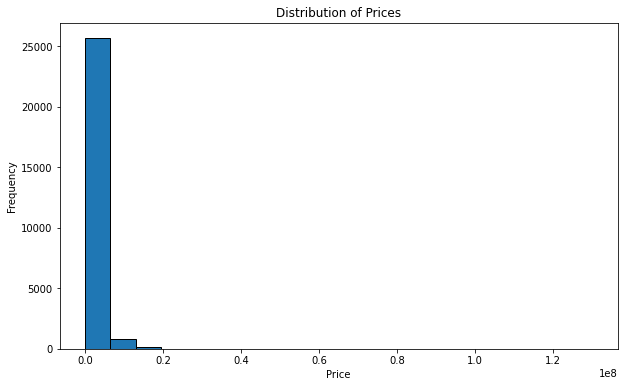

Скос: 13.55232917349533


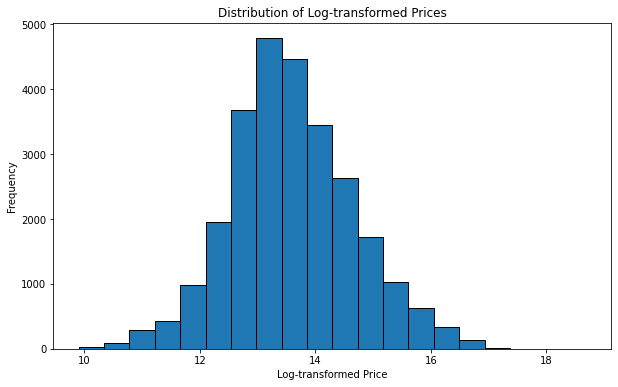

In [17]:
price_distribution()

2	Выведите круговую диаграмму по типам переменных

In [18]:
def split_columns_by_type(df) -> list:
    num_cols = [col for col in df.columns if df[col].dtype != object]
    cat_cols = [col for col in df.columns if df[col].dtype == object]

    return [num_cols, cat_cols]


In [19]:
def print_diagram_types(df):
    # Подсчет количества переменных каждого типа

    numerical_cols, categorical_cols = split_columns_by_type(df)

    # Подсчет количества переменных каждого типа
    num_numerical_cols = len(numerical_cols)
    num_categorical_cols = len(categorical_cols)

    # Построение круговой диаграммы
    labels = ['Numerical', 'Categorical']
    sizes = [num_numerical_cols, num_categorical_cols]

    fig, ax = plt.subplots()
    ax.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, colors=['lightblue', 'lightcoral', 'lightgray'])
    ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

    plt.title('Distribution of Variable Types Including Empty Values')
    plt.show()

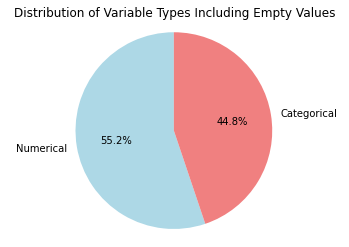

In [20]:
print_diagram_types(df)

In [21]:
df.to_csv("auto_sample.csv")

3.	Выведите гистограмму распределения по маркам машин

In [483]:
df['mark'].isna().sum()

0

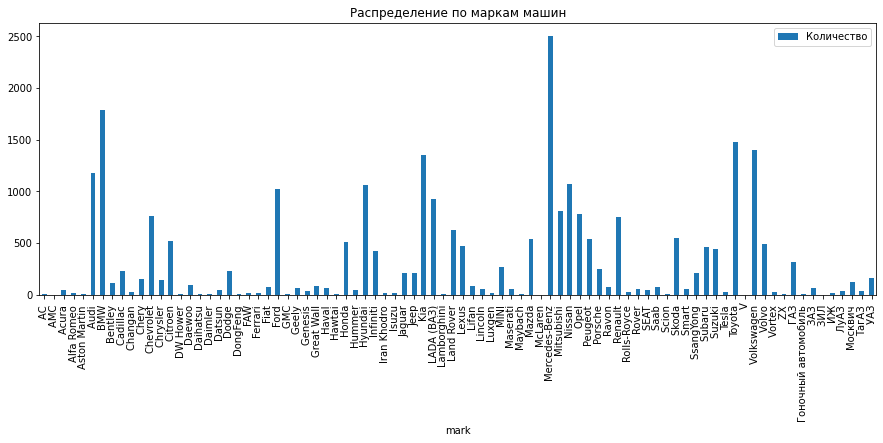

In [484]:
plt.figure(figsize=(16,8))
df.groupby(['mark']).size().plot(kind = 'bar',figsize=(15,5), title = 'Распределение по маркам машин', label = 'Количество')
plt.legend()

4.	Постройте гистограммы и ящиковые диаграммы распределений категориальных признаков в зависимости от цены машин (по всем признакам). Сделайте выводы.

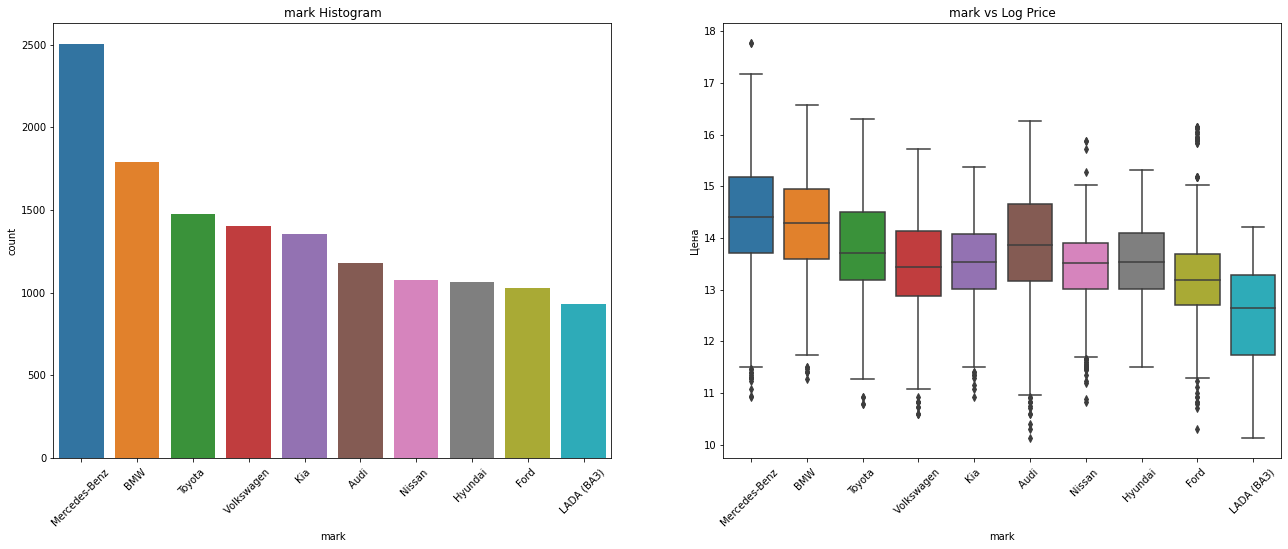

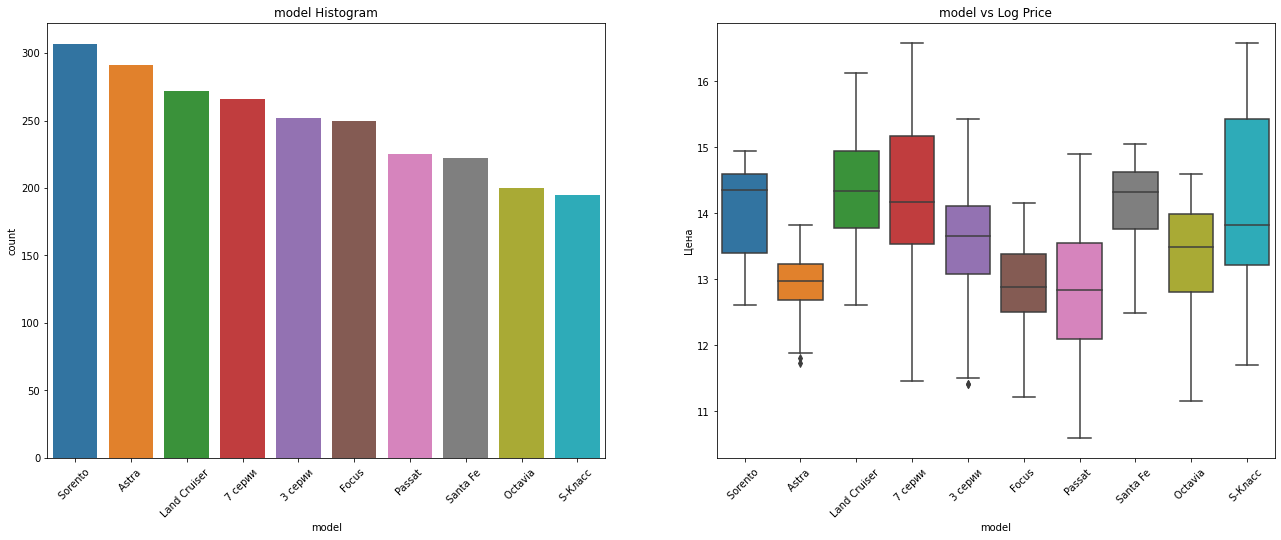

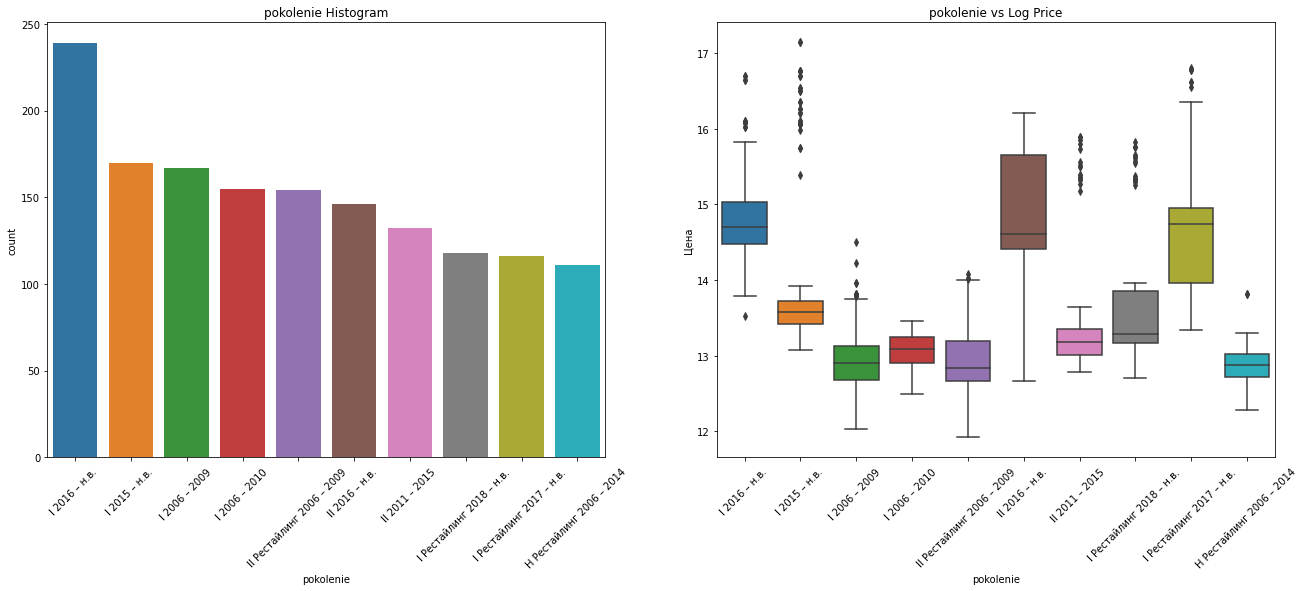

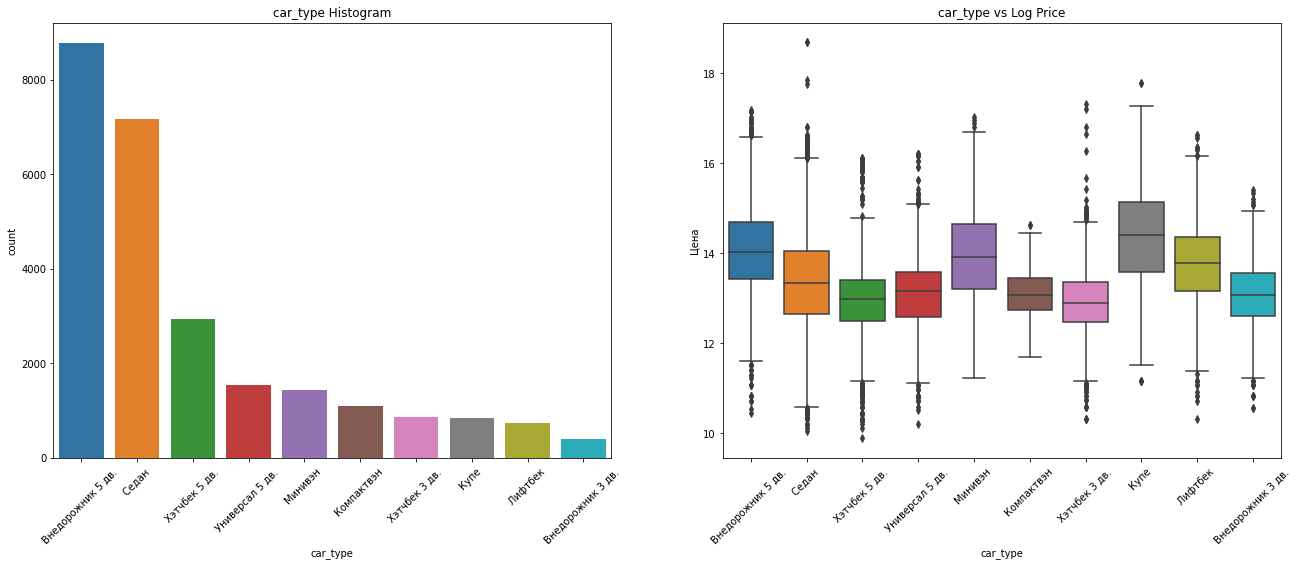

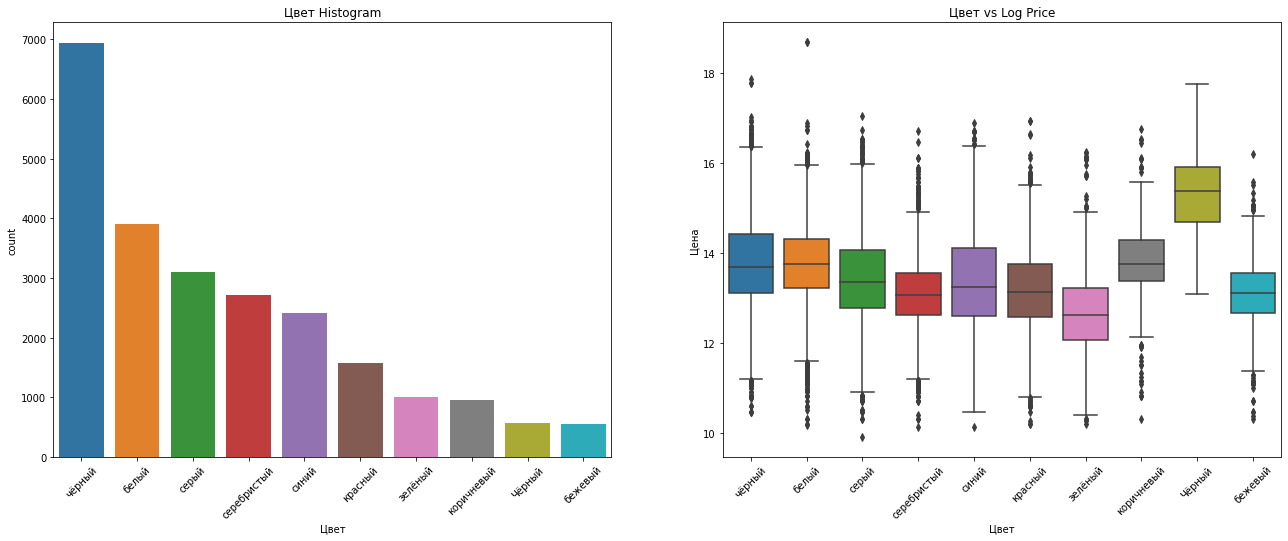

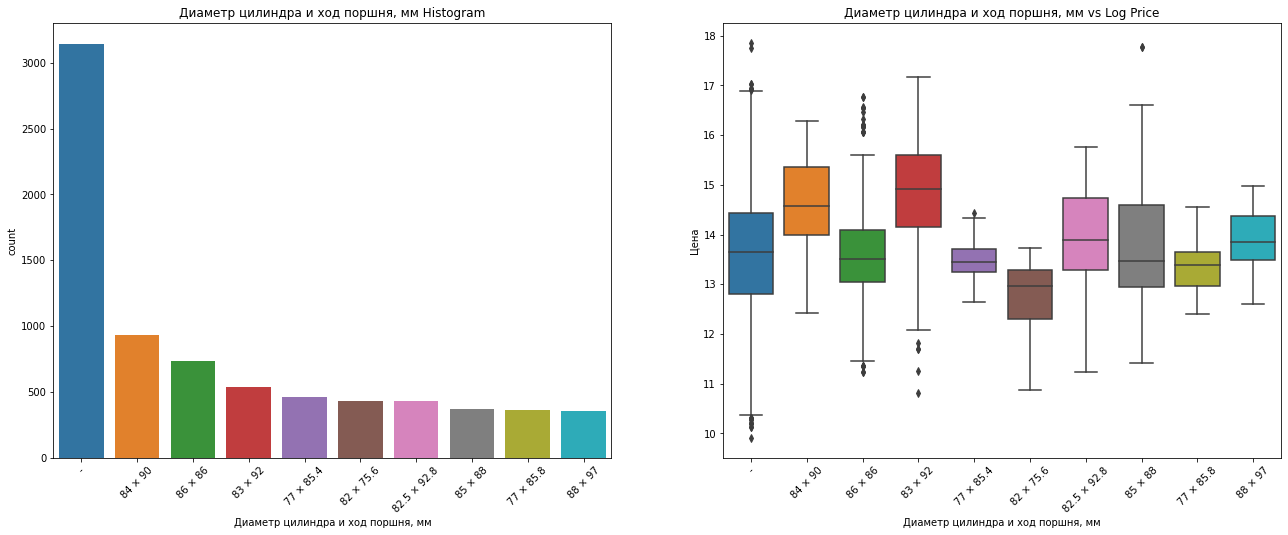

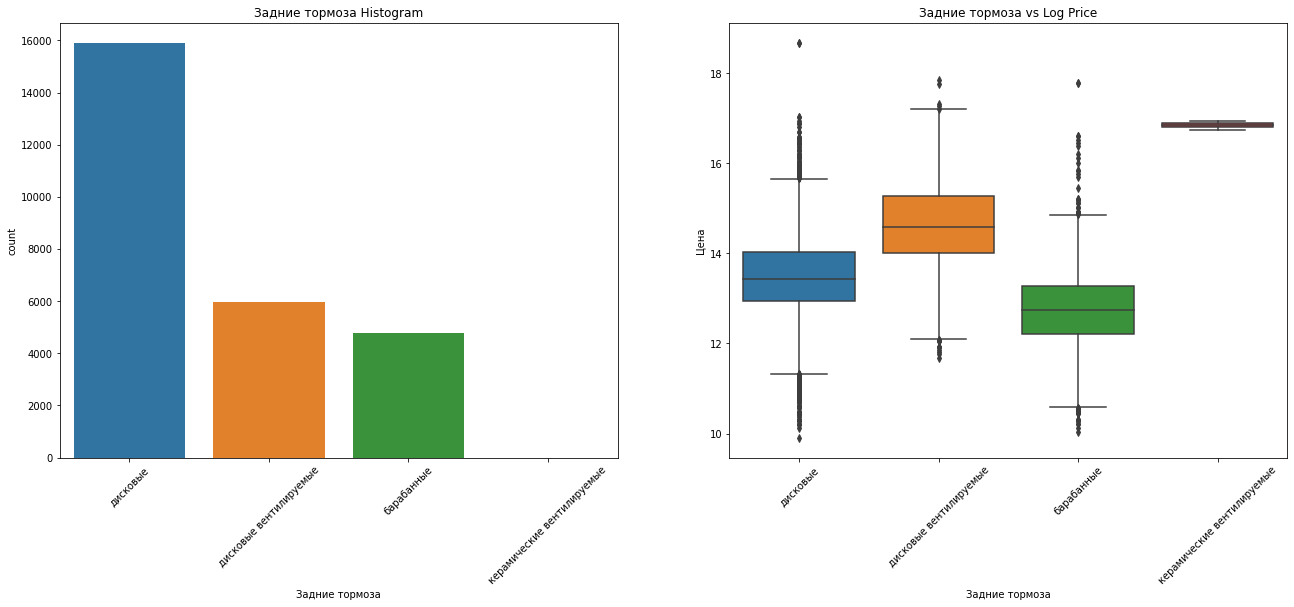

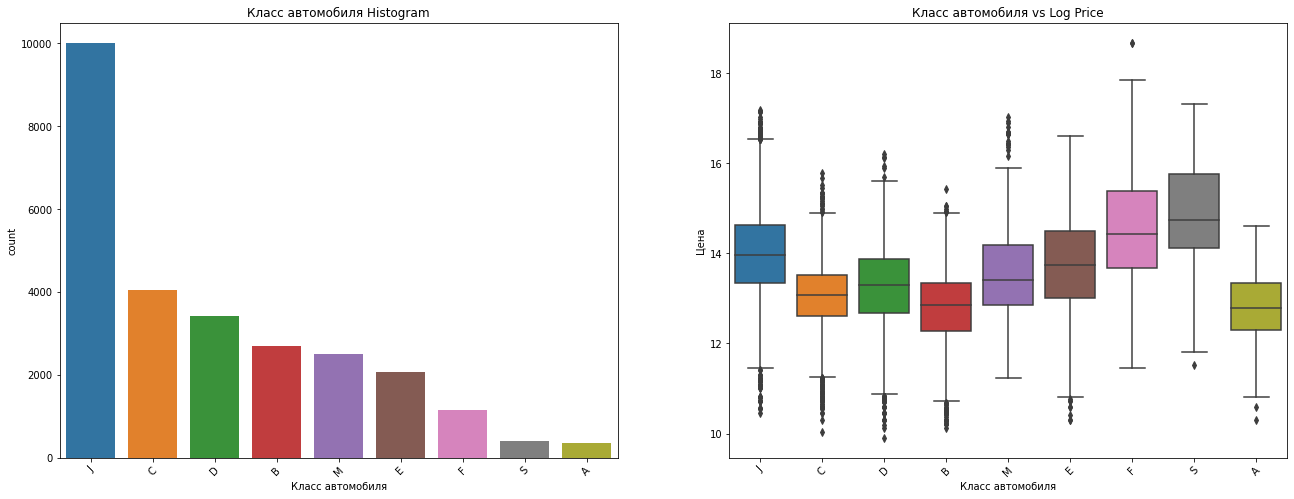

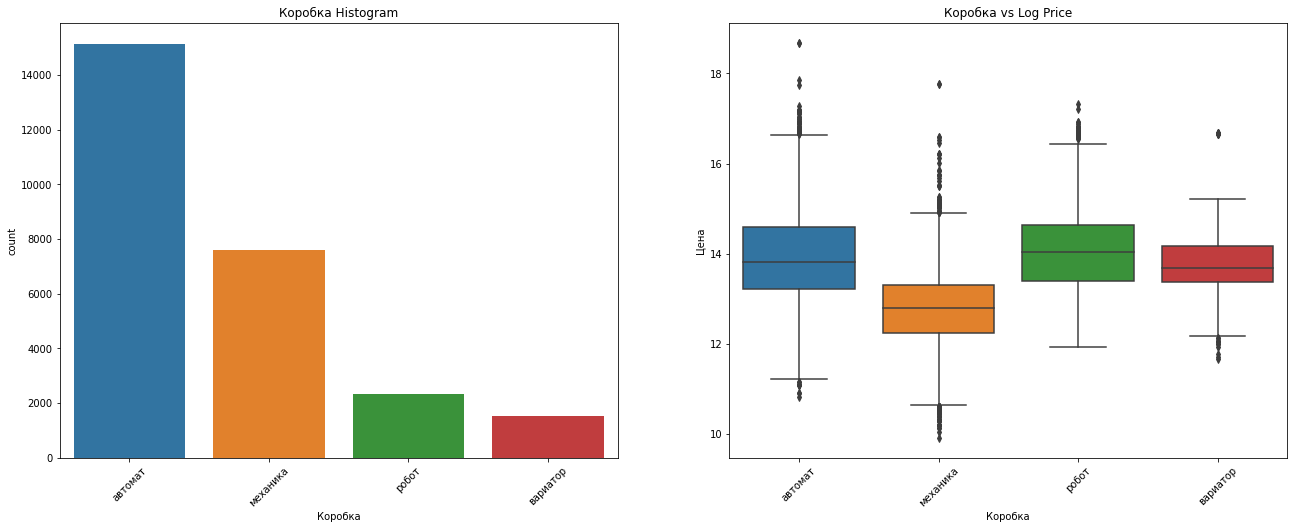

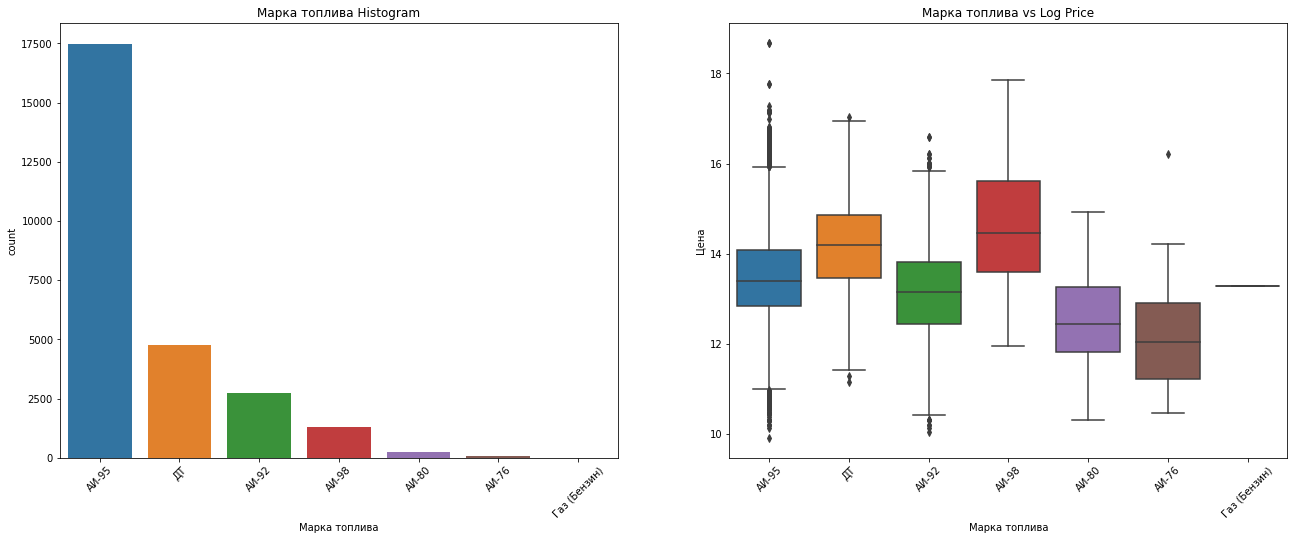

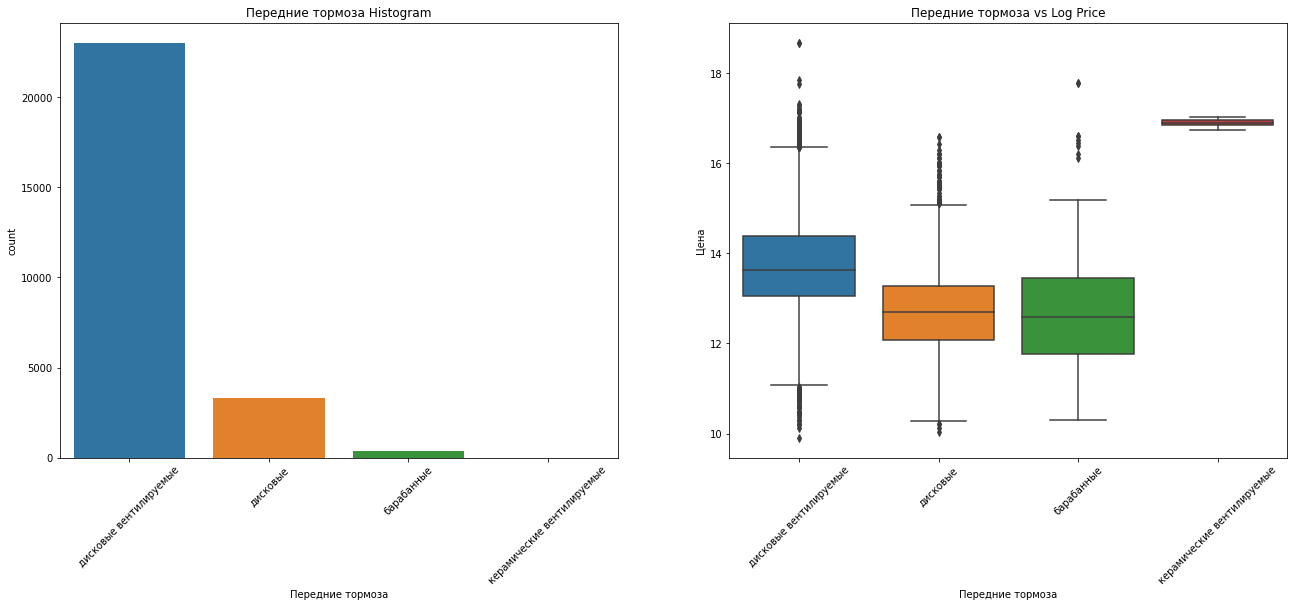

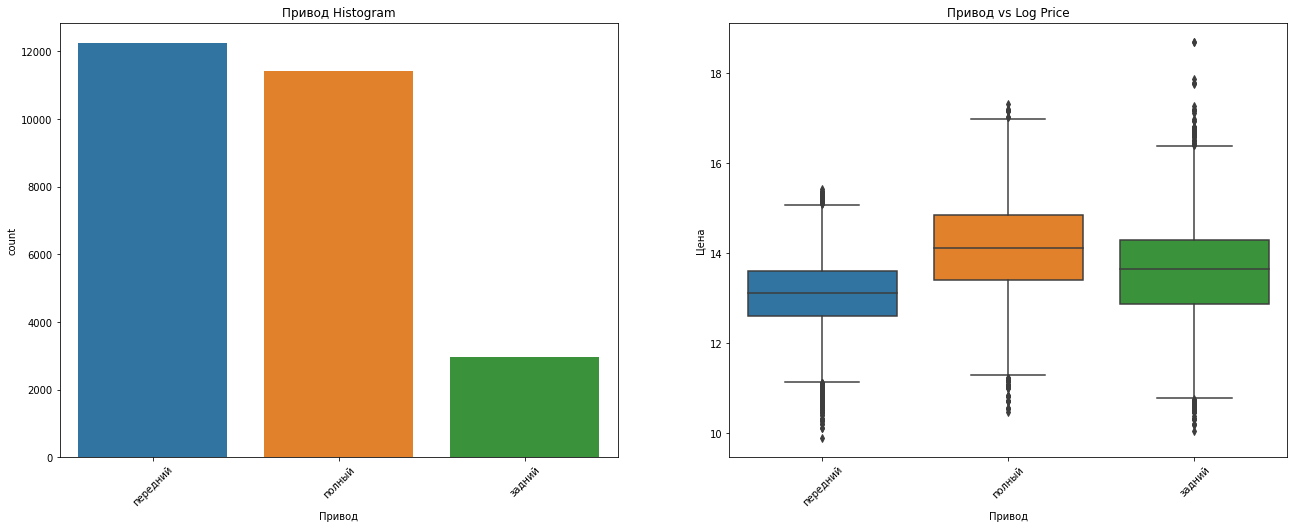

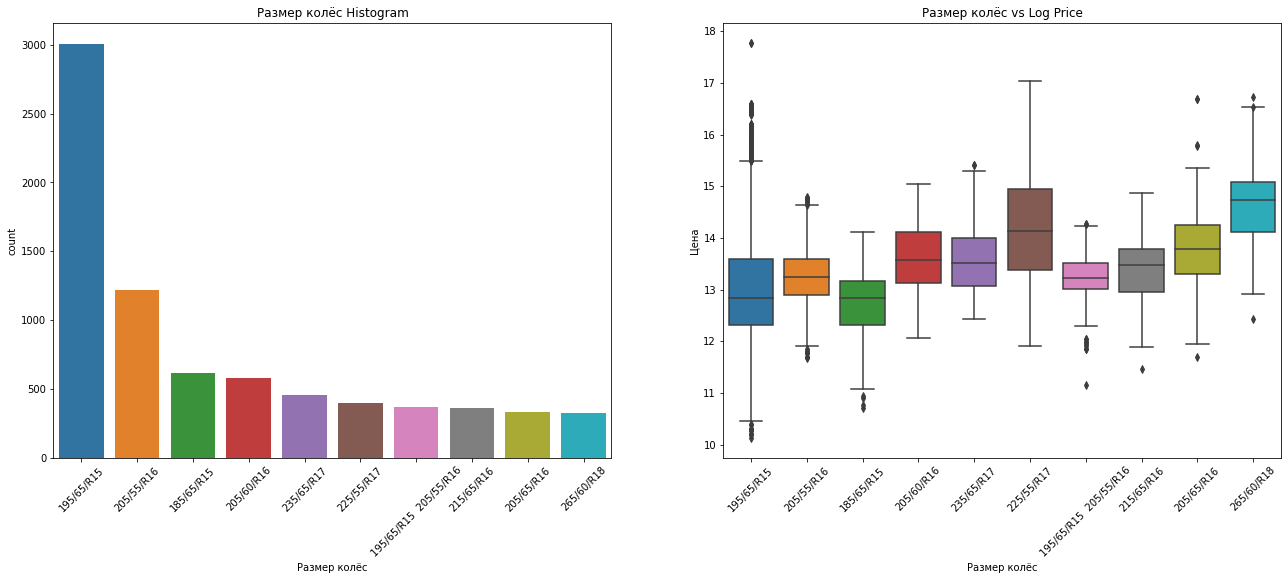

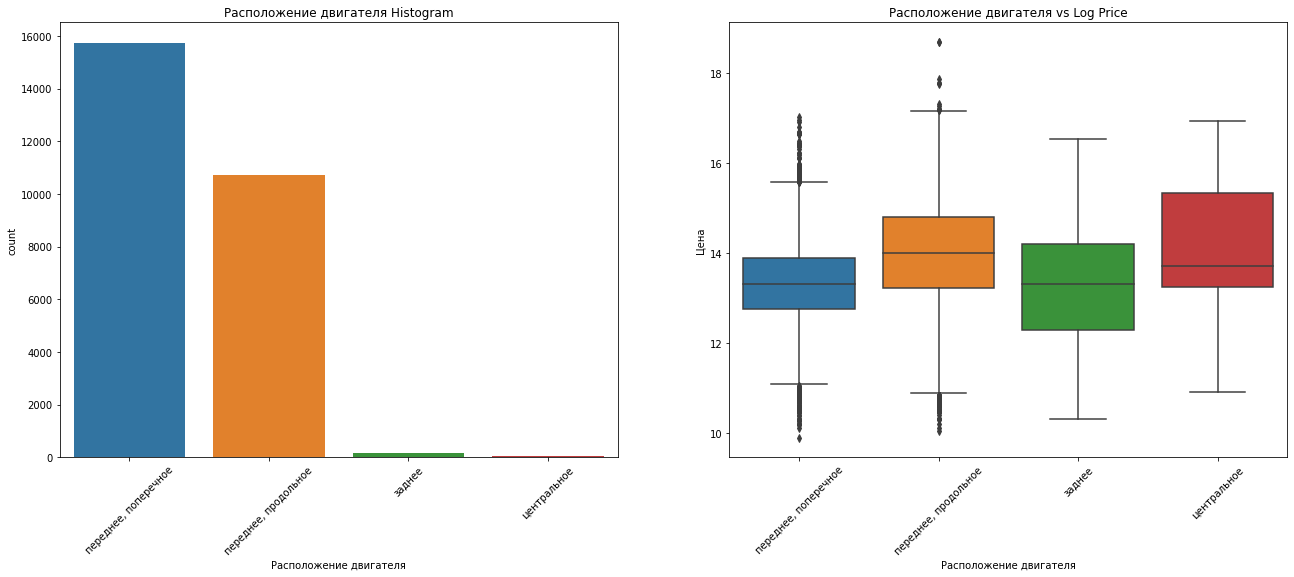

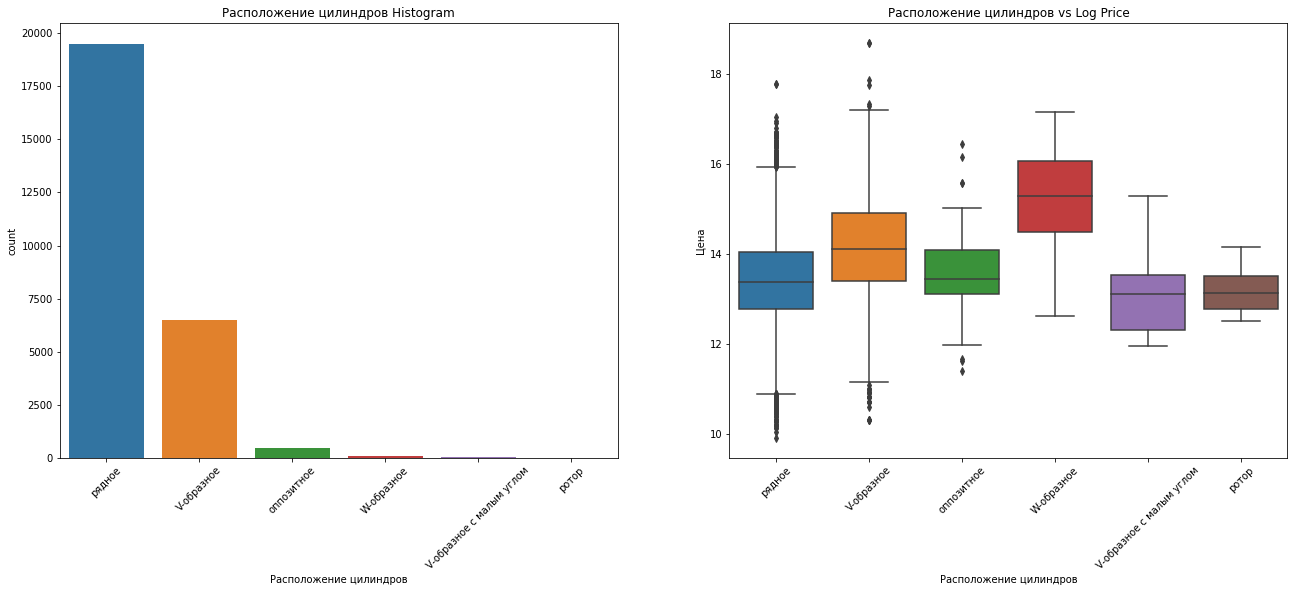

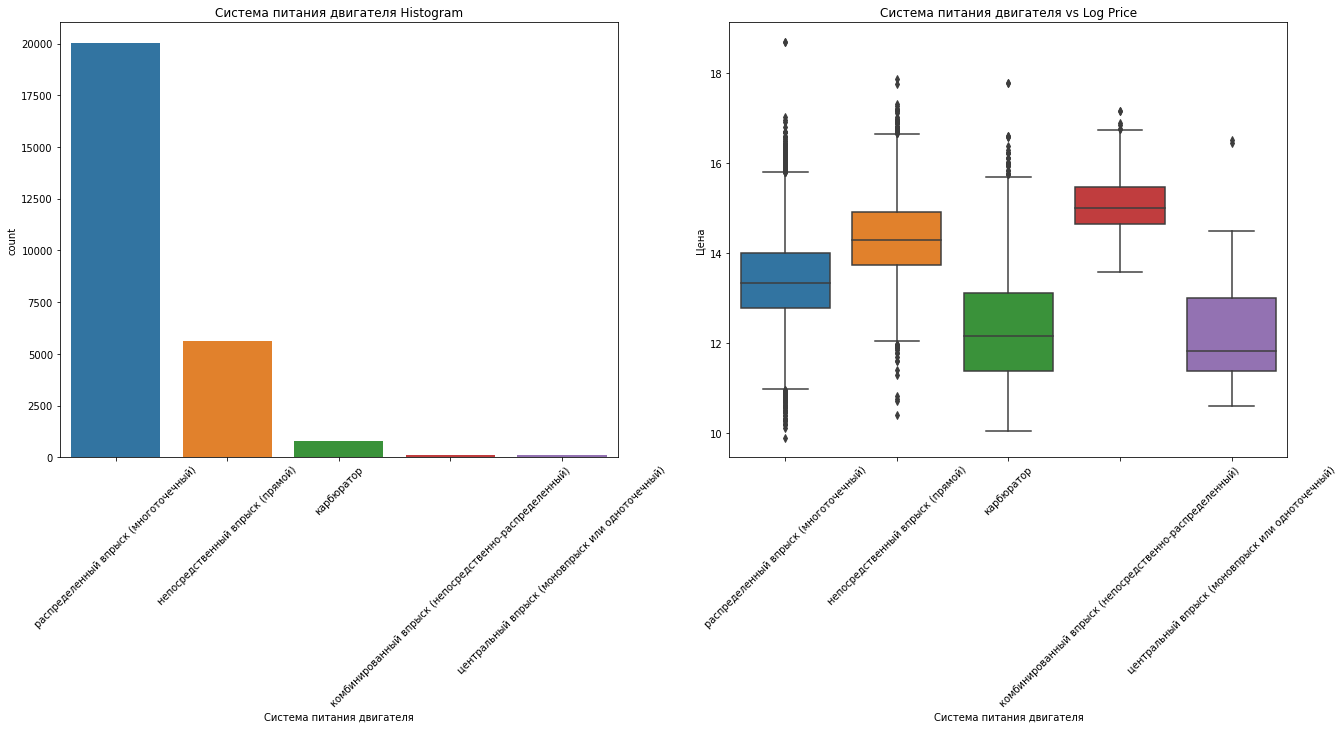

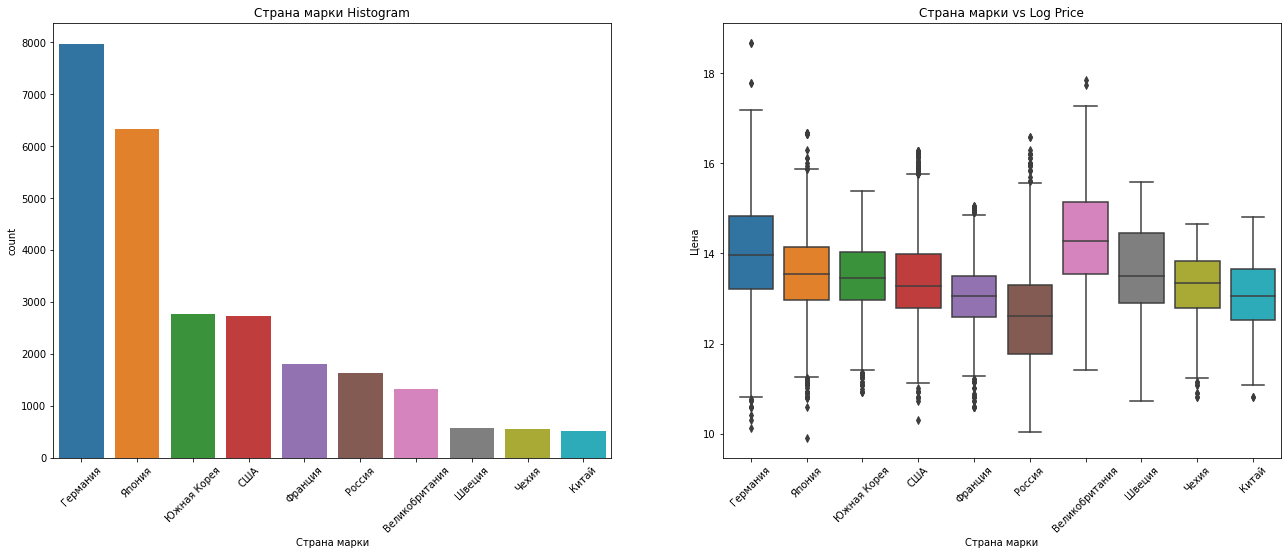

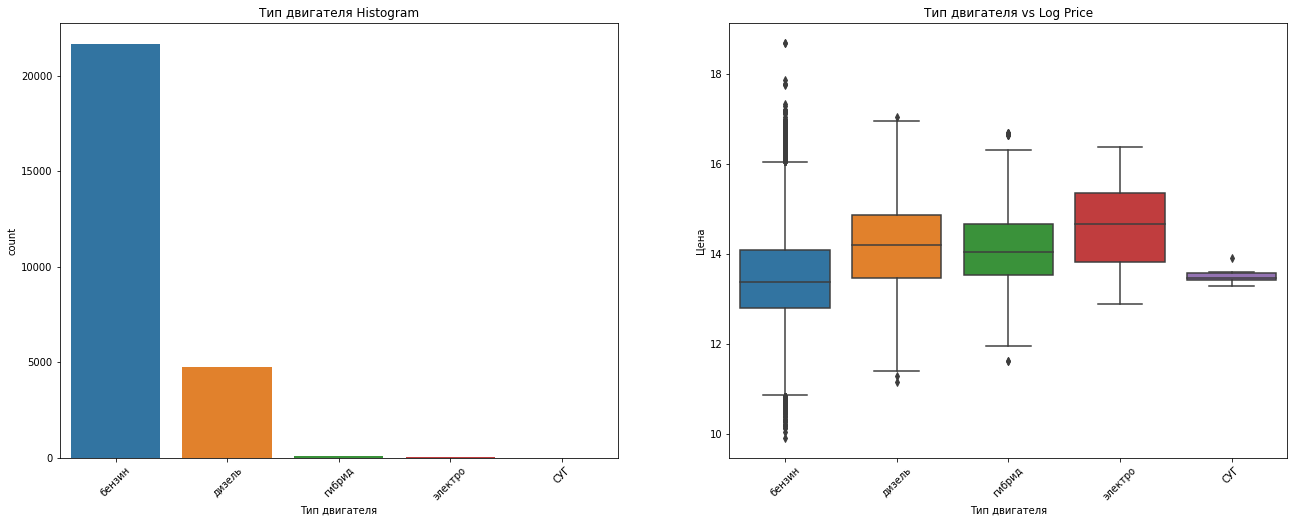

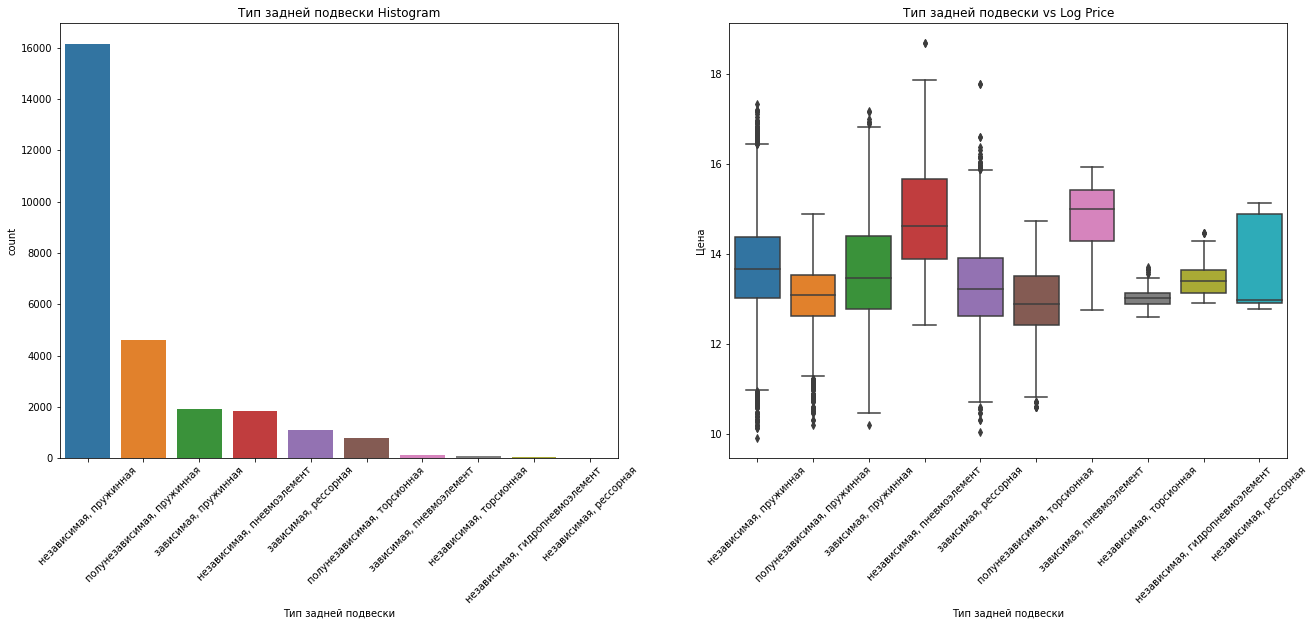

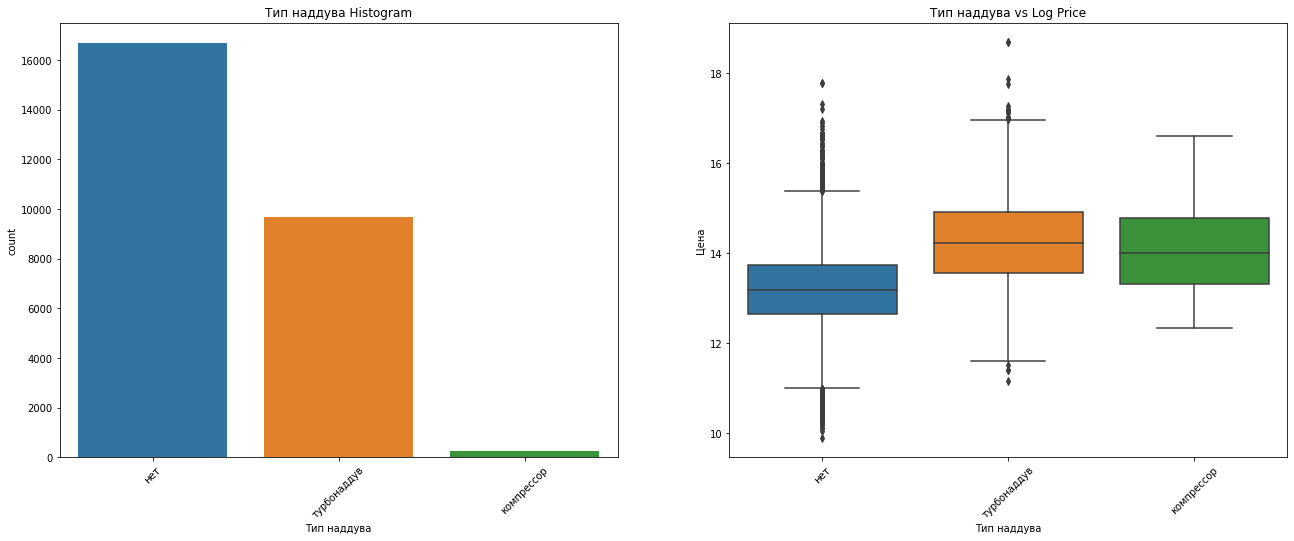

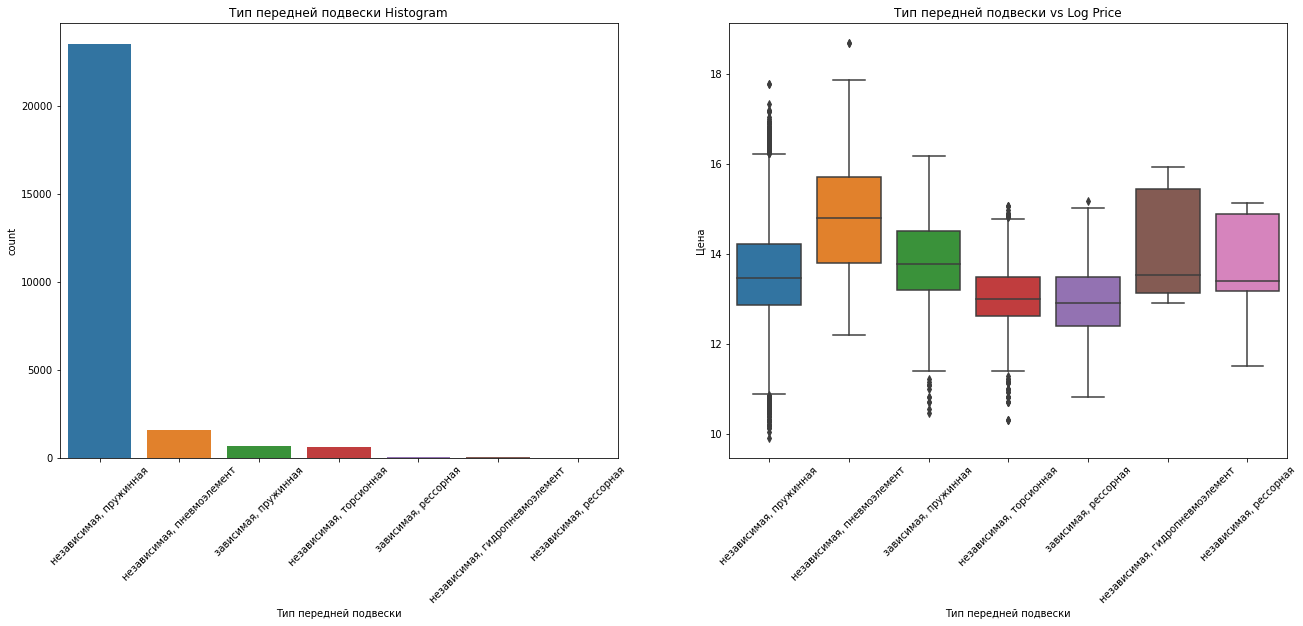

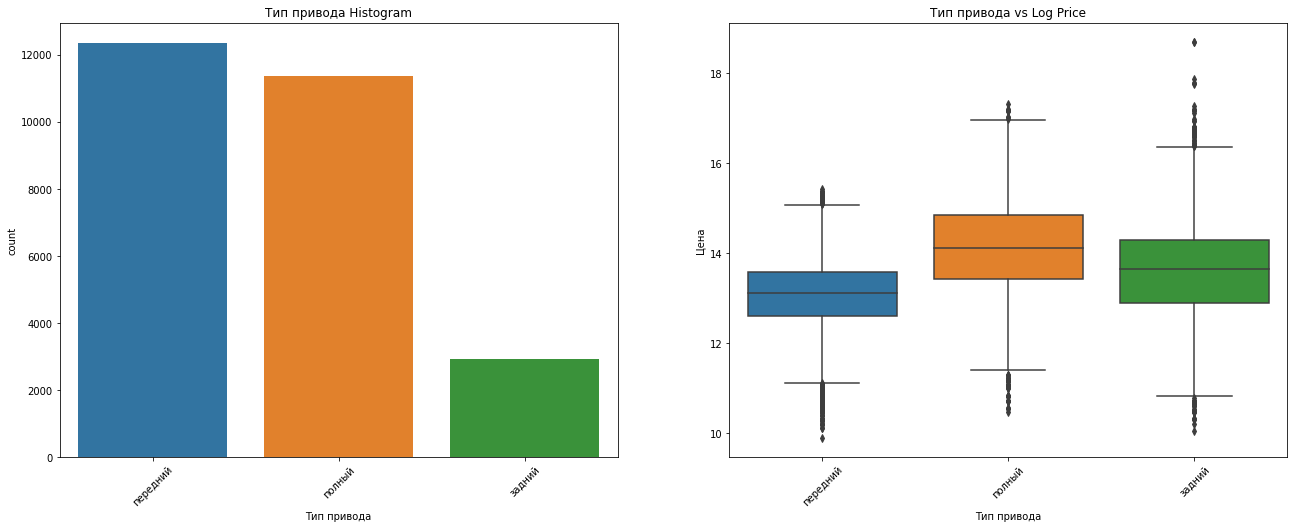

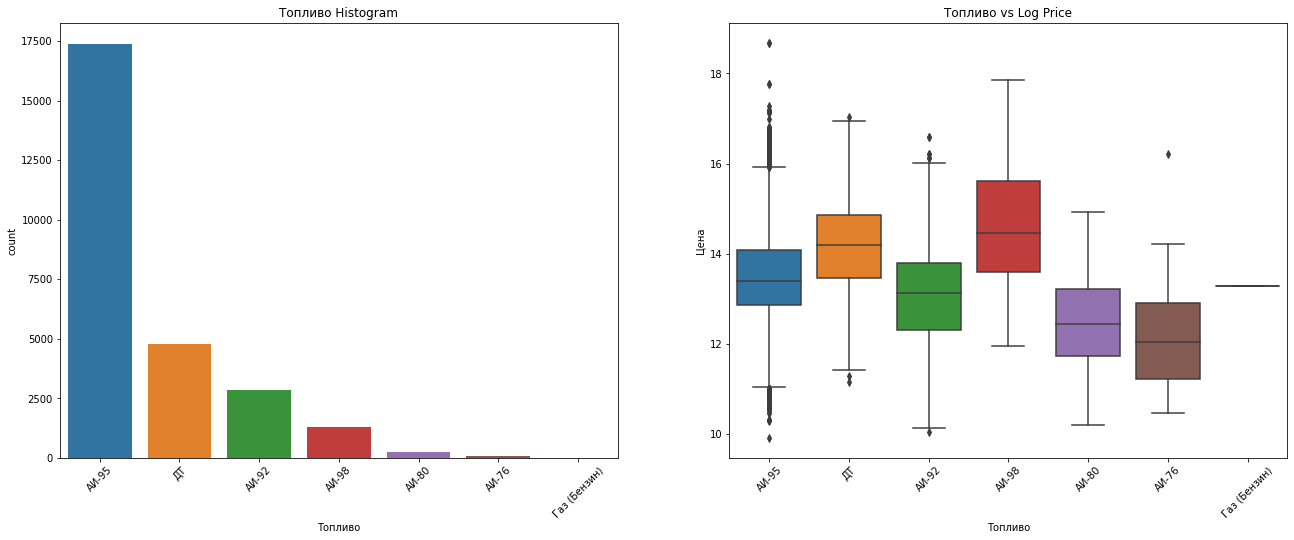

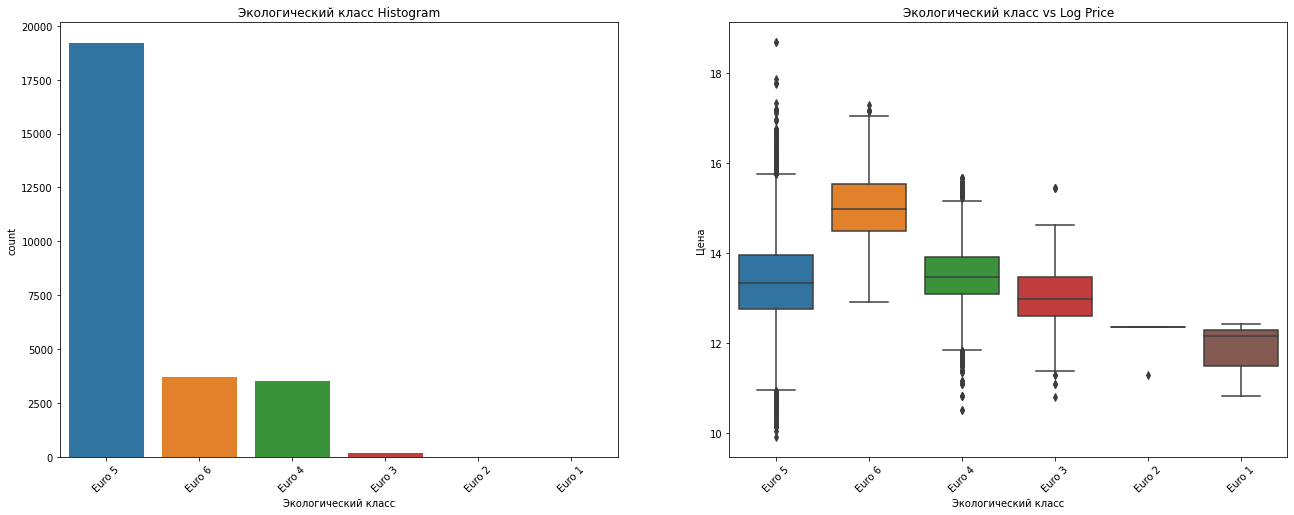

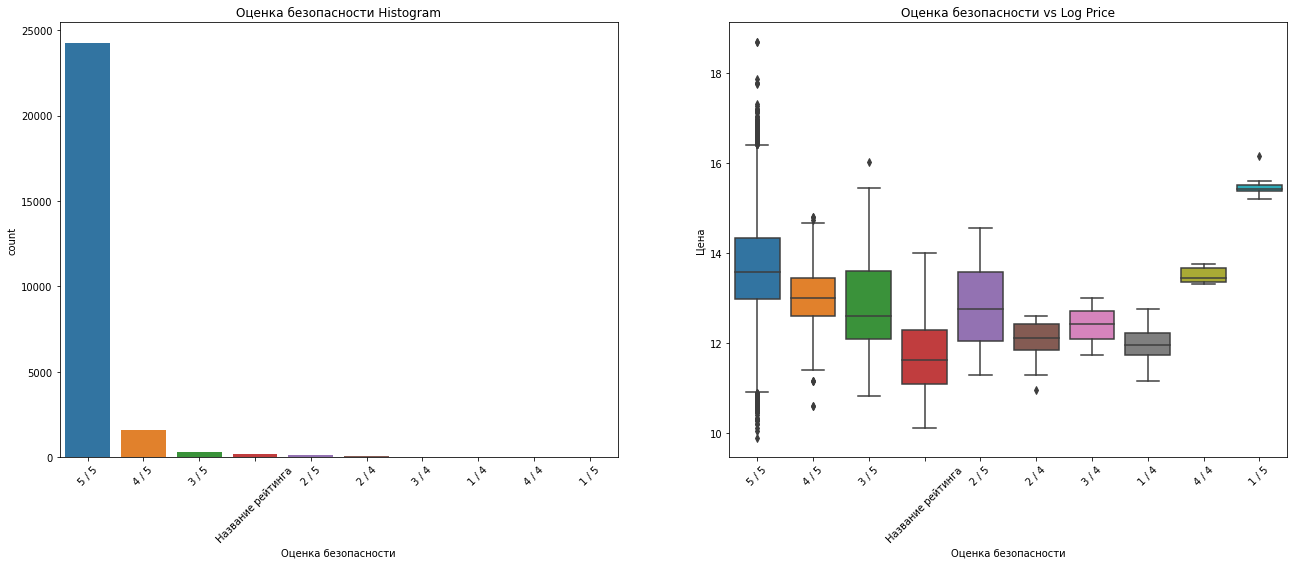

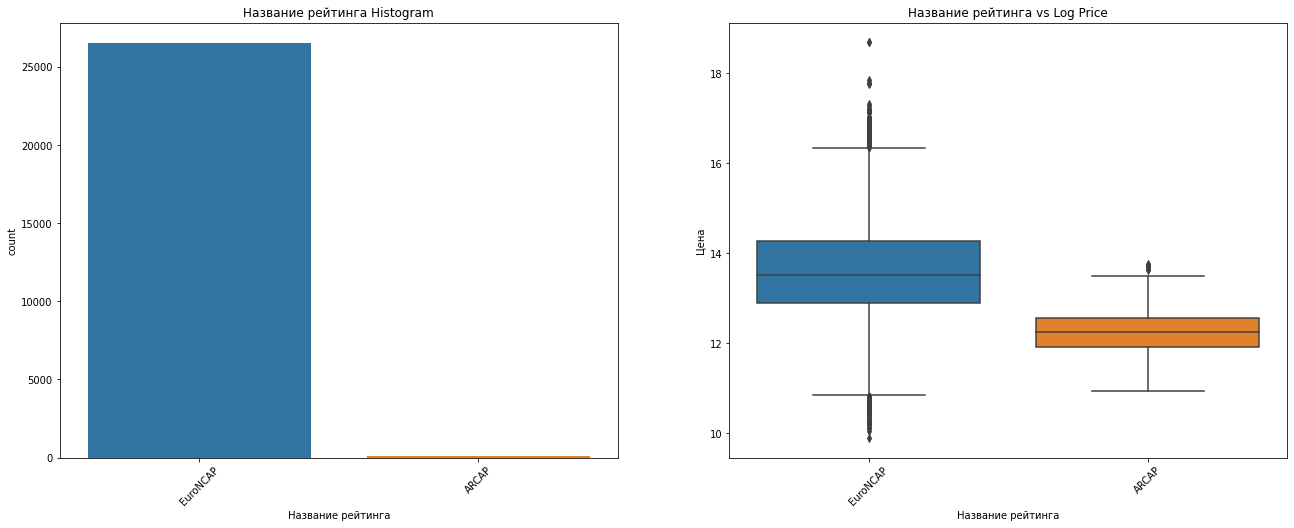

In [485]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def plot_categorical_columns(df, categorical_cols):
    for column in categorical_cols:
        # Получаем 10 наиболее часто встречающихся значений
        column_most_freq = df[column].value_counts()[:10].sort_values(ascending=False).index
        
        # Убираем пустые значения, если они есть
        column_most_freq = column_most_freq.dropna()

        fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(22, 8))

        plt.subplot(1, 2, 1)
        plt.title(f'{column} Histogram')
        sns.countplot(
            df[df[column].isin(column_most_freq)][column],
            order=column_most_freq
        )
        plt.xticks(rotation=45)

        plt.subplot(1, 2, 2)
        plt.title(f'{column} vs Log Price')
        ax = sns.boxplot(
            x=df[df[column].isin(column_most_freq)][column],
            y=np.log(df[df[column].isin(column_most_freq)].Цена),
            order=column_most_freq
        )
        plt.xticks(rotation=45)

        plt.show()

# Замените df на ваш DataFrame
# Пусть get_columns - ваша функция, возвращающая числовые и категориальные колонки
numerical_cols, categorical_cols = split_columns_by_type(df)

# Применяем функцию для визуализации категориальных переменных
plot_categorical_columns(df, categorical_cols)


5.	Для количественных признаков постройте диаграммы рассеивания. Сделайте выводы.

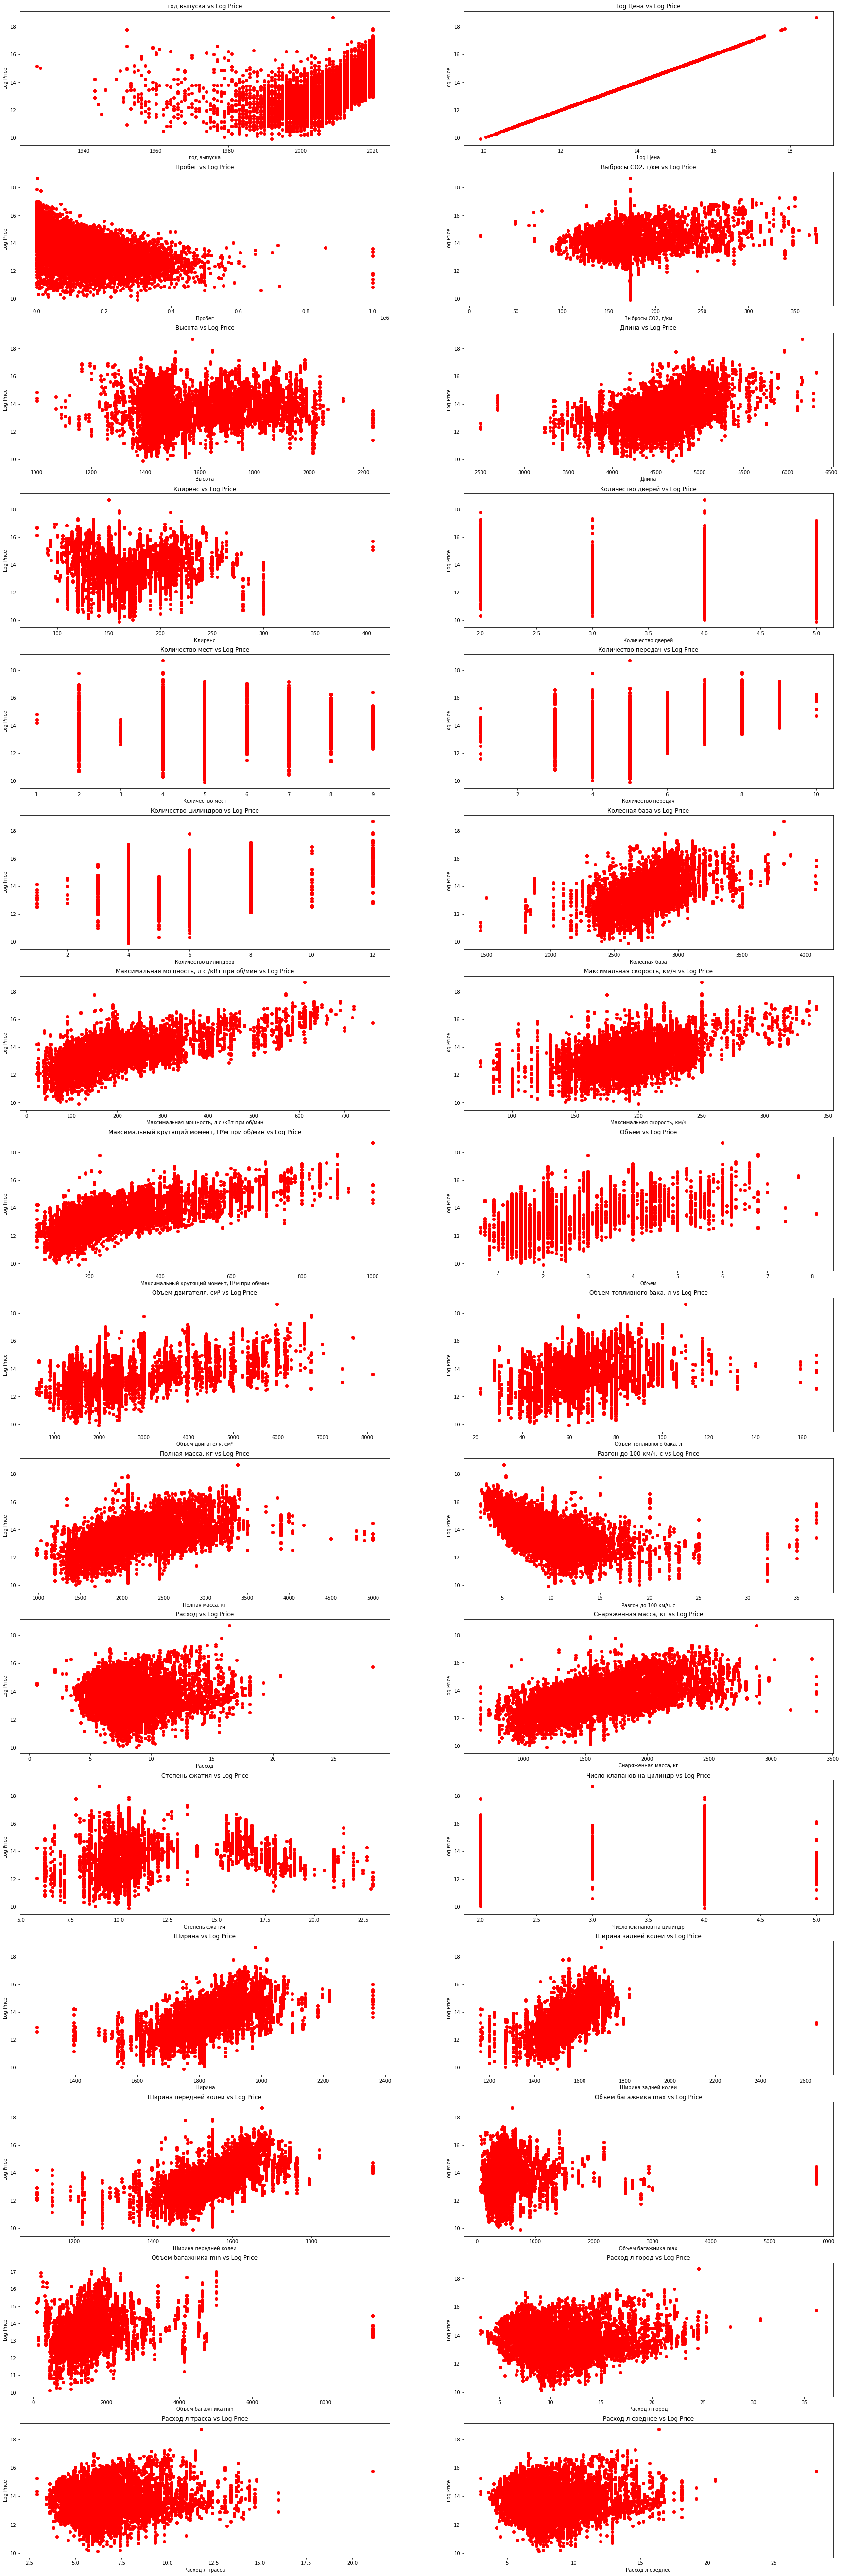

In [486]:
def scatter(column,fig):
    plt.subplot(33,2,fig)
    ax = plt.scatter(
        x=[price if 'Цена' not in column else np.log(price) for price in df[df[column] > 0][column]],
        y=np.log(df[df[column] > 0].Цена),
        color = 'red'
    )
    plt.title(f'{column} vs Log Price', fontsize=40)
    plt.title(f'{column} vs Log Price' if 'Цена' not in column else f'Log {column} vs Log Price')
    plt.ylabel('Log Price')
    plt.xlabel(column if 'Цена' not in column else f'Log {column}')

plt.figure(figsize=(30,200))

for i, column in enumerate(numerical_cols):
    scatter(column, i + 1)


6.	Постройте гистограмма корреляций значений признаков и текущей цены автомобиля. Сделайте выводы.

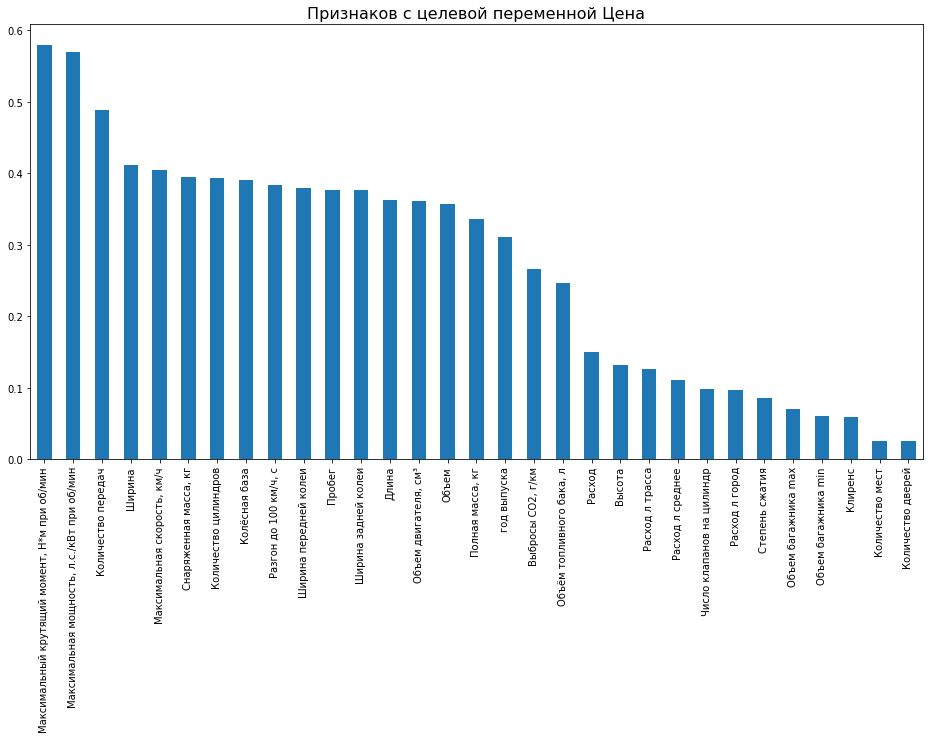

In [487]:
def plot_correlation(df, target_column, figsize=(16, 8)):
    correlation_series = abs(df.corr()[target_column]).sort_values(ascending=False)[1:]
    plt.figure(figsize=figsize)
    correlation_series.plot(kind='bar')
    plt.title(f'Признаков с целевой переменной {target_column}', fontsize=16)
    plt.show()

target_column = 'Цена'

plot_correlation(df, target_column)
